# Mixed Domain

## Data

The pickle file contains a dictionary:
* x_<train/valid>: data point with 2 feature columns
* y_<train/valid>: label
* d_<train/valid>: domain

The train-valid split is:
* Train: 2400 datapoints
* Valid: 300 datapoints

In [1]:
import pickle
data = pickle.load(open("./data/data_d0.25.pkl", "rb"))

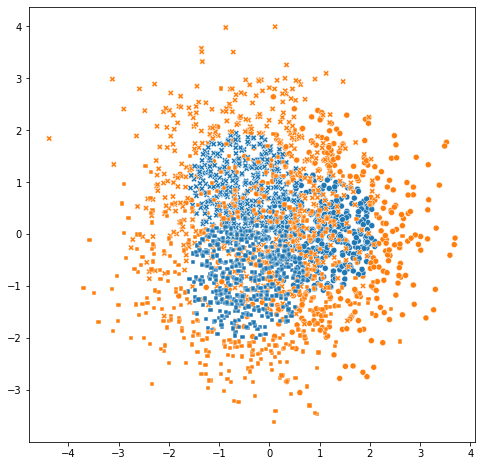

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(x=data['x_train'][:, 0], y=data['x_train'][:, 1],
                hue=data['y_train'], style=data['d_train'], legend=False
)

plt.show()

## Assignment Specifications

* Goal: To create a multi-domain FFNN of 2 hidden layers (20, 10) with ReLU as activation function.
* Report accuracy performance stats on validation set for random seeds [0, 10, 1234, 99, 2021].
* Train each model for 30,000 epochs using Adam optimizer (LR: 1e-3).


# Question 1: Implement a basic FNN (multi-domain model training)

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.3529152274131775
INFO:util.loop:Validation loss: 0.4620324373245239
INFO:util.loop:Train acc: 83.20833%
INFO:util.loop:Validation acc: 79.00000%


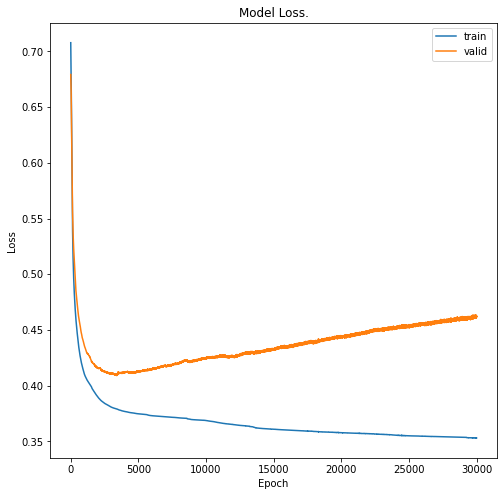

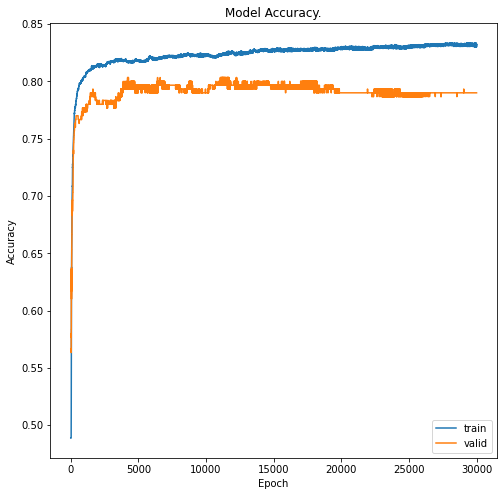

In [3]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
model = FFNN(random_state=0)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
model, _ = train(data, model, epochs, batch_size, optimizer, plot=True)



Random State 0:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.3529152274131775
INFO:util.loop:Validation loss: 0.4620324373245239
INFO:util.loop:Train acc: 83.20833%
INFO:util.loop:Validation acc: 79.00000%


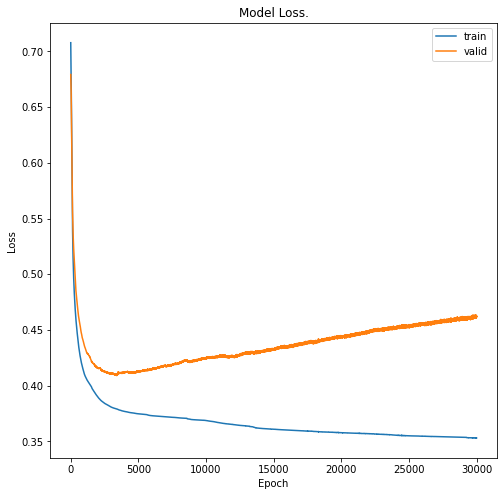

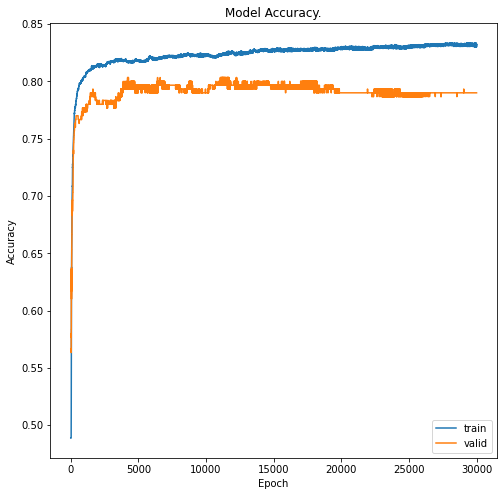



Random State 10:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.36674028635025024
INFO:util.loop:Validation loss: 0.5497980117797852
INFO:util.loop:Train acc: 82.12500%
INFO:util.loop:Validation acc: 78.33334%


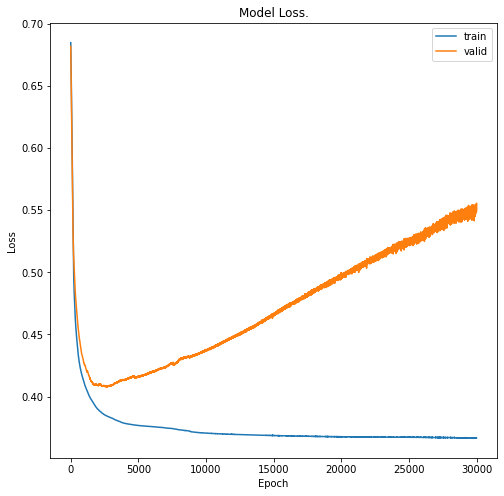

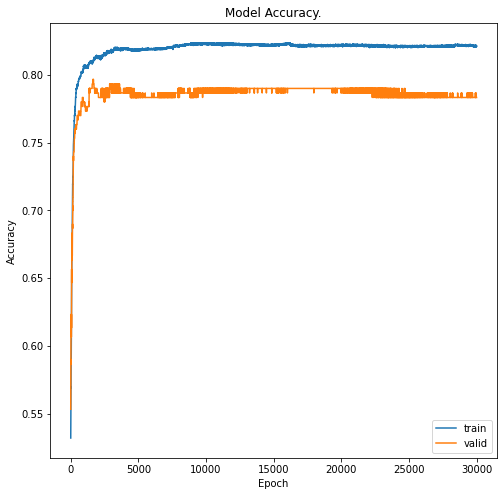



Random State 1234:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.3480689227581024
INFO:util.loop:Validation loss: 0.4979984760284424
INFO:util.loop:Train acc: 83.20833%
INFO:util.loop:Validation acc: 78.33334%


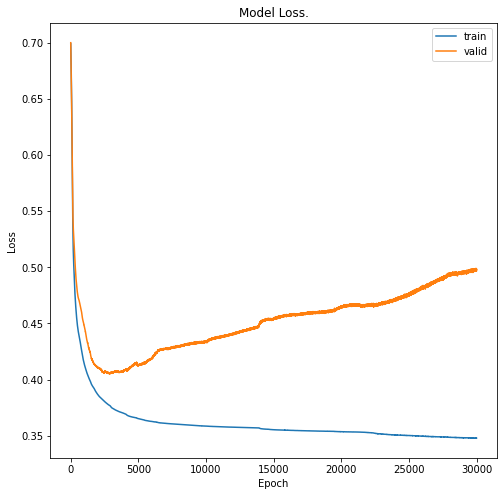

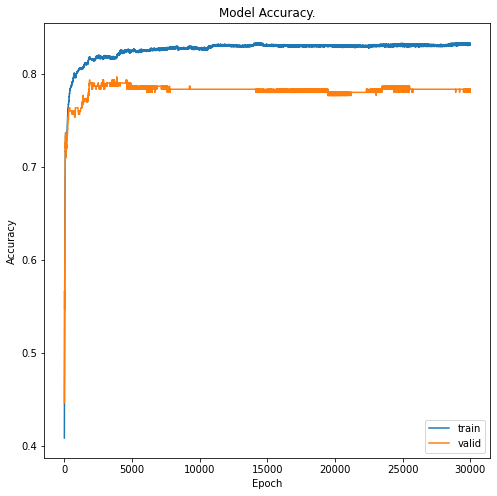



Random State 99:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.35436007380485535
INFO:util.loop:Validation loss: 0.46593064069747925
INFO:util.loop:Train acc: 82.79167%
INFO:util.loop:Validation acc: 77.33334%


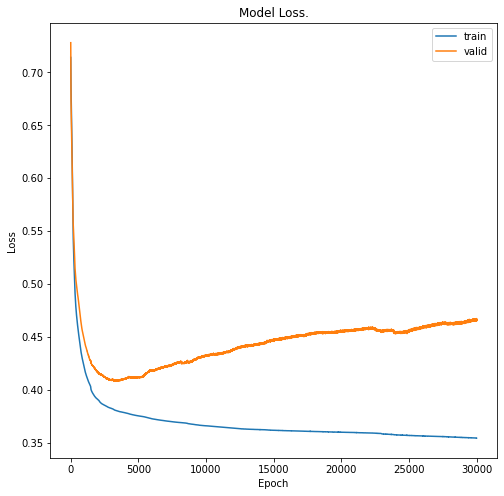

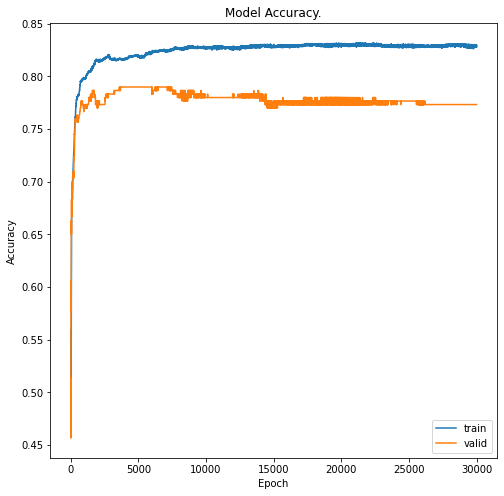



Random State 2021:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.3609216511249542
INFO:util.loop:Validation loss: 0.43830156326293945
INFO:util.loop:Train acc: 82.70833%
INFO:util.loop:Validation acc: 81.00000%


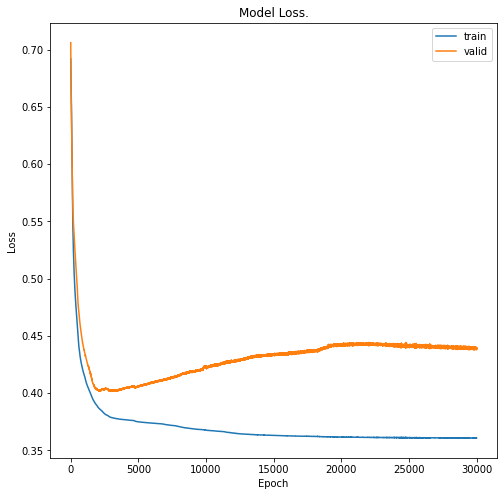

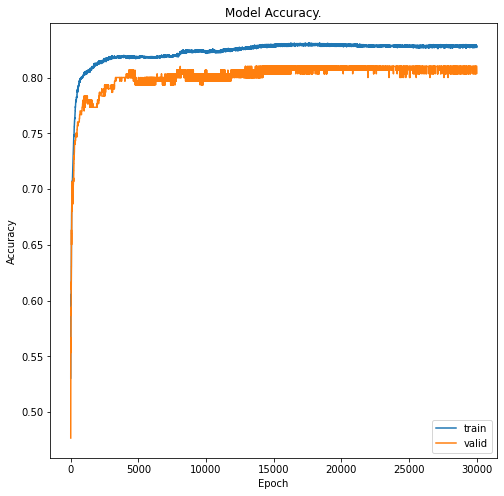

In [4]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    print(f"\n\nRandom State {random_state}:")
    _, valid_acc = train(data, model, epochs, batch_size, optimizer, validate=True, plot=True, logfile=f"data0.25_q1_random_state_{random_state}")
    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 78.800002% +/- 0.013662587991607775


# Creating a dictionary of different domain data

Needs to be created for the following questions.

In [3]:
Data = {}
for domain in set(data['d_train']):
    Data[domain] = {}
    for data_set in ['train', 'valid']:
        index = data[f'd_{data_set}']==domain
        for key in data.keys():
            if data_set in key: Data[domain][key] = data[key][index]

# Question 2: Implement a multi-domain model using knowledge distillation

## Teacher Model Training



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.937150440056712e-09
INFO:util.loop:Validation loss: 0.2120191752910614
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%


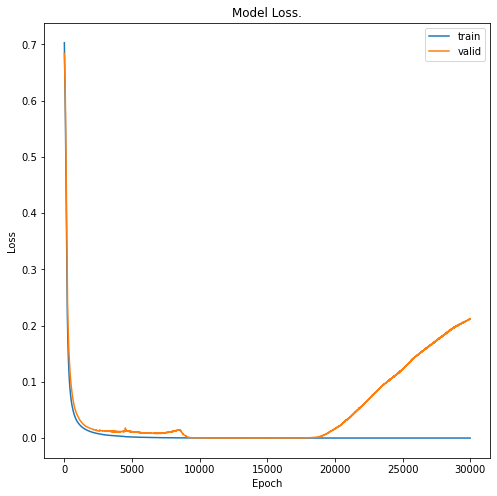

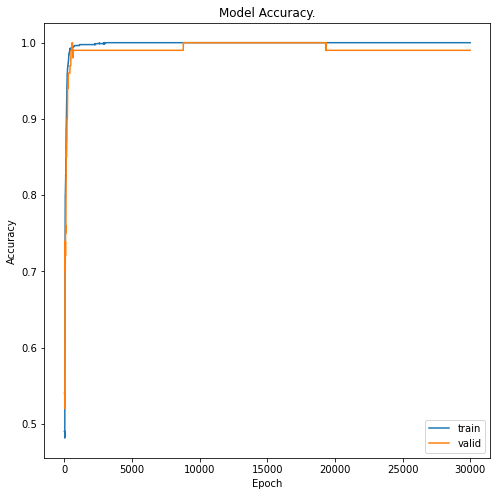



 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 8.940695961356937e-10
INFO:util.loop:Validation loss: 0.08900623023509979
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%


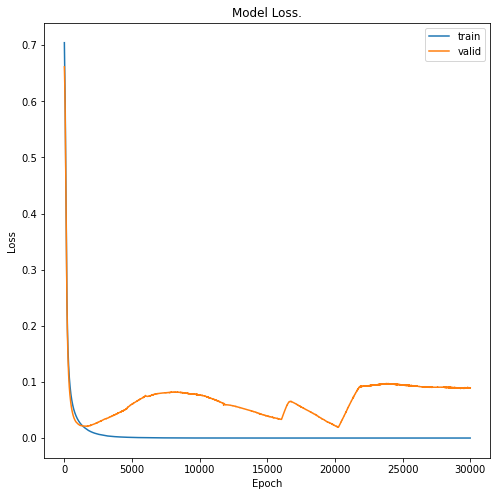

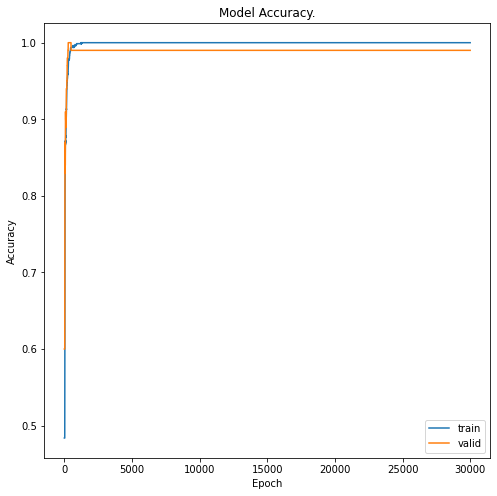



 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1920927578401574e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%


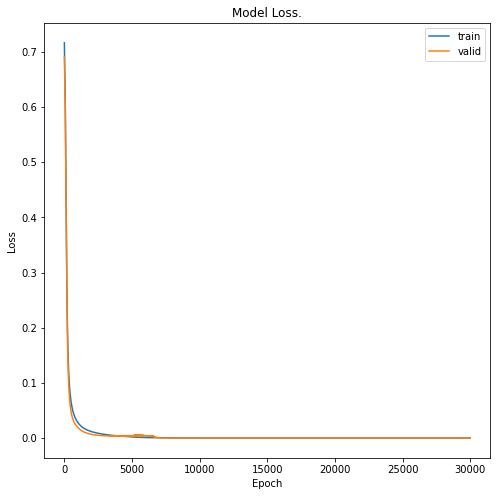

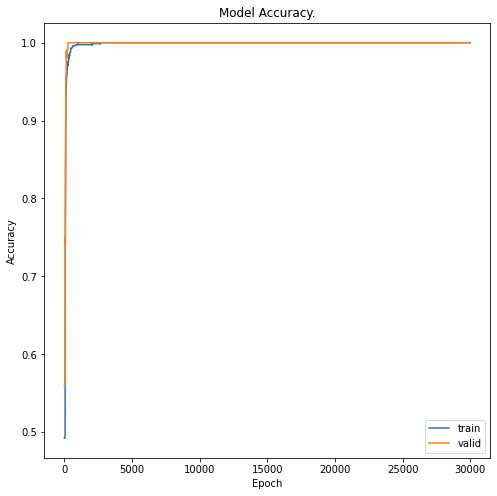

In [7]:
import torch
from util.model import FFNN
from util.loop import train

Teacher_Model = {}
for domain in set(data['d_train']):
    epochs = 30000
    batch_size = len(Data[domain]['x_train'])   # batch gradient descent
    Teacher_Model[domain] = FFNN(random_state=0)
    optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
    print(f"\n\n Teacher Model Training for Domain {domain}")
    Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, plot=True)

## Storing logits offline infered from trained teacher models

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for domain in set(data['d_train']):
    with torch.no_grad(): 
        Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
        Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

## Student Training

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 59.62823486328125
INFO:util.loop:Validation loss: 62.99843978881836
INFO:util.loop:Train acc: 81.20833%
INFO:util.loop:Validation acc: 78.00000%


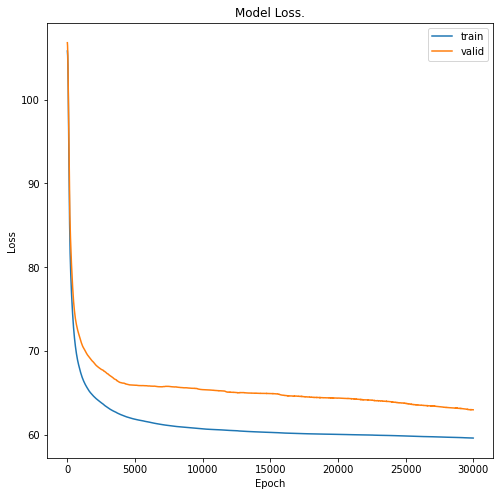

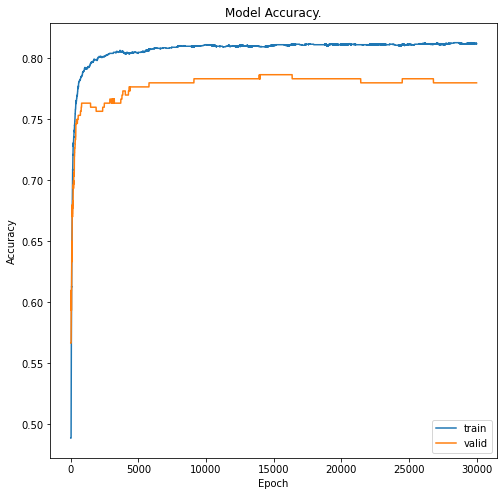

In [9]:
import torch
from util.model import FFNN
from util.loop import student_train

epochs = 30000
batch_size_ratio = 1.0   # batch gradient descent
alpha = 0.5
T = 18.0
Student_Model = FFNN(random_state=0)
optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
Student_Model, _ = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, plot=True)

## Complete run using 5 random states



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.937150440056712e-09
INFO:util.loop:Validation loss: 0.2120191752910614
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 8.940695961356937e-10
INFO:util.loop:Validation loss: 0.08900623023509979
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1920927578401574e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 59.62823486328125
INFO:util.loop:Validation loss: 62.99843978881836
INFO:util.loop:Train acc: 81.20833%
INFO:util.loop:Validation acc: 78.00000%


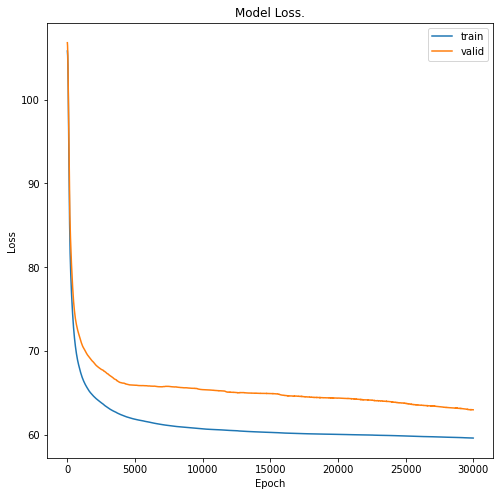

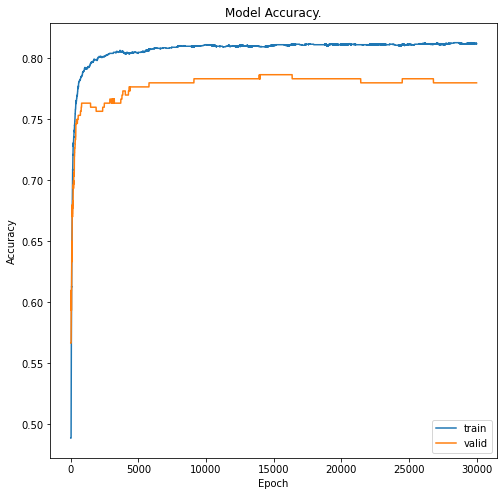



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.595209924853407e-07
INFO:util.loop:Validation loss: 0.0017134713707491755
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 7.450579597723106e-10
INFO:util.loop:Validation loss: 4.649151108537808e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.3411043386923893e-09
INFO:util.loop:Validation loss: 1.1920927578401574e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 47.61439514160156
INFO:util.loop:Validation loss: 51.7879753112793
INFO:util.loop:Train acc: 80.33333%
INFO:util.loop:Validation acc: 75.33333%


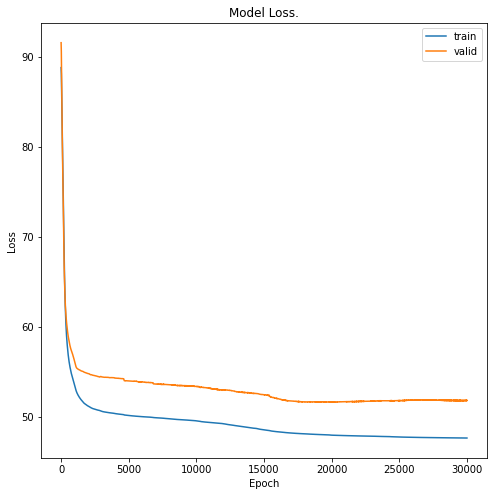

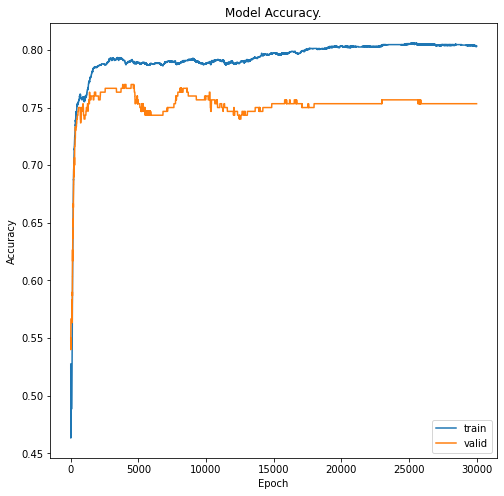



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.427265360400611e-09
INFO:util.loop:Validation loss: 0.7283796668052673
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.00000%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.2351733797165707e-09
INFO:util.loop:Validation loss: 0.296792209148407
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1920927578401574e-09
INFO:util.loop:Validation loss: 3.313963645723561e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 58.034732818603516
INFO:util.loop:Validation loss: 62.48563003540039
INFO:util.loop:Train acc: 81.25000%
INFO:util.loop:Validation acc: 78.00000%


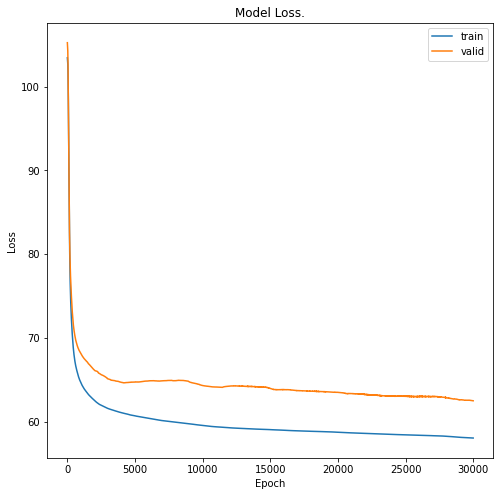

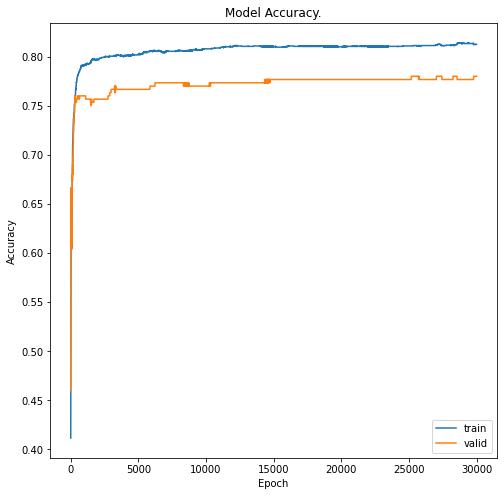



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.8312194810808933e-09
INFO:util.loop:Validation loss: 0.36862120032310486
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.0430811769879256e-09
INFO:util.loop:Validation loss: 0.008105803281068802
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.937150662101317e-09
INFO:util.loop:Validation loss: 3.6715786677632423e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 61.219390869140625
INFO:util.loop:Validation loss: 65.42549896240234
INFO:util.loop:Train acc: 80.87500%
INFO:util.loop:Validation acc: 76.66667%


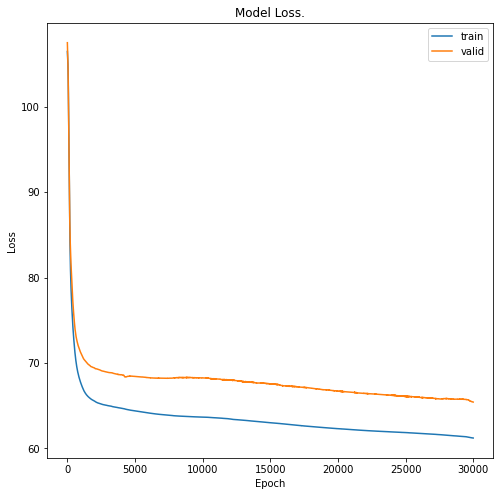

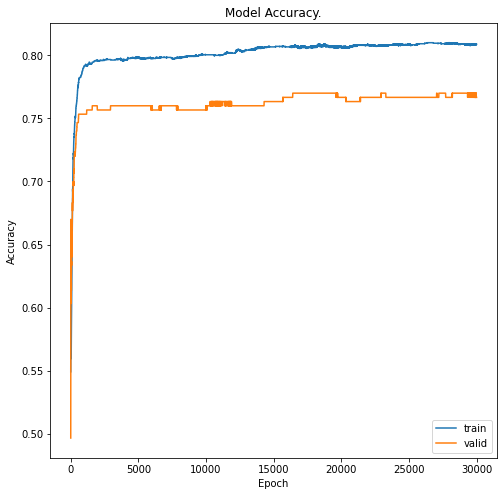



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 2.038417648009272e-07
INFO:util.loop:Validation loss: 0.4098747670650482
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1920927578401574e-09
INFO:util.loop:Validation loss: 0.3261292278766632
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.129243308919172e-09
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 58.2700309753418
INFO:util.loop:Validation loss: 61.56283187866211
INFO:util.loop:Train acc: 81.74999%
INFO:util.loop:Validation acc: 78.66666%


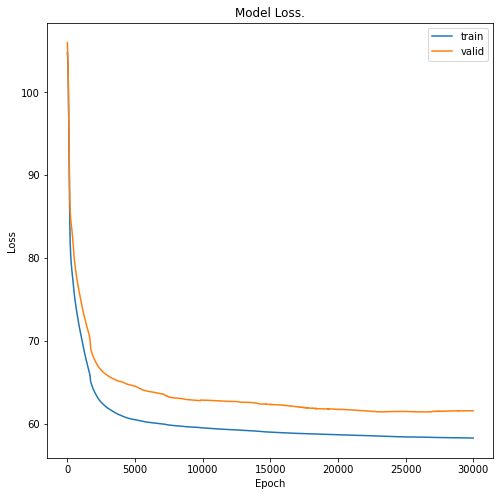

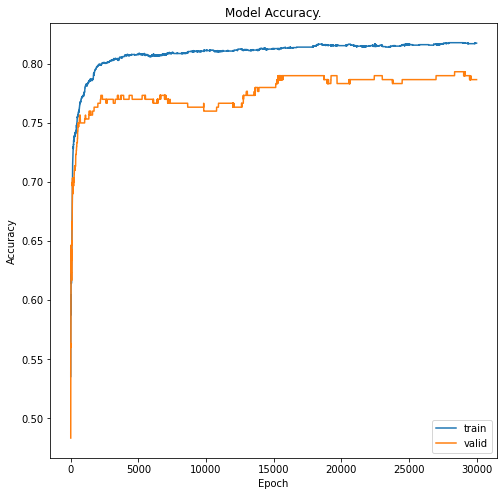

In [10]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:

    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain}")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, 
                                         plot=False, logfile=f"data0.25_q2_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.5
    T = 18.0
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, 
                                             plot=True, logfile=f"data0.25_q2_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)

In [11]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 77.333331% +/- 0.013333320617675781


# Question 3: Ways to improve

## Method 1: Tuning and Checkpointing best model.

Tuning alpha value to shift weightage between soft label training and hard label training. Early stopping at least validation loss checkpoint for the teacher and student also helps improving the final results.



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 13094 based on val_loss
INFO:util.loop:Train loss: 1.653385152167175e-05
INFO:util.loop:Validation loss: 8.034537017920229e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 20253 based on val_loss
INFO:util.loop:Train loss: 1.00730794372339e-07
INFO:util.loop:Validation loss: 0.019461367279291153
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 14320 based on val_loss
INFO:util.loop:Train loss: 4.400189482112182e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Checkpoint Epoch 29904 based on val_loss
INFO:util.loop:Train loss: 9.68576431274414
INFO:util.loop:Validation loss: 10.057398796081543
INFO:util.loop:Train acc: 81.70834%
INFO:util.loop:Validation acc: 78.66666%


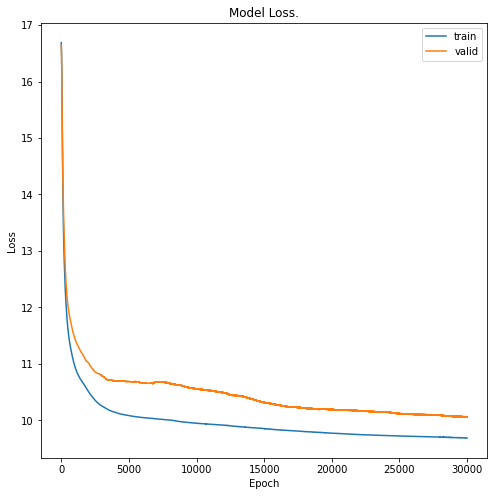

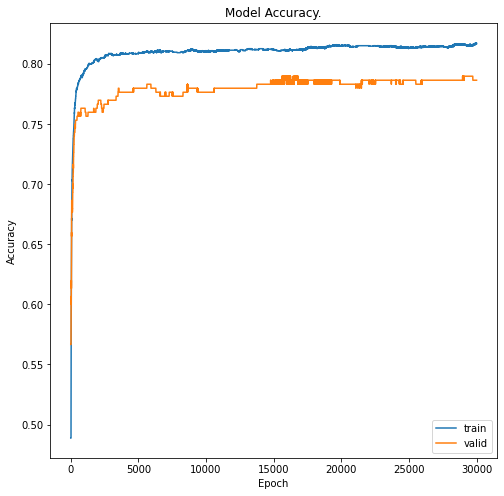



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 21910 based on val_loss
INFO:util.loop:Train loss: 1.8265681092088926e-06
INFO:util.loop:Validation loss: 1.3455706721288152e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 29917 based on val_loss
INFO:util.loop:Train loss: 7.450579597723106e-10
INFO:util.loop:Validation loss: 4.529942287945232e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 28464 based on val_loss
INFO:util.loop:Train loss: 2.384185515680315e-09
INFO:util.loop:Validation loss: 1.1920927578401574e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Checkpoint Epoch 29238 based on val_loss
INFO:util.loop:Train loss: 8.393694877624512
INFO:util.loop:Validation loss: 9.247536659240723
INFO:util.loop:Train acc: 81.66667%
INFO:util.loop:Validation acc: 77.33333%


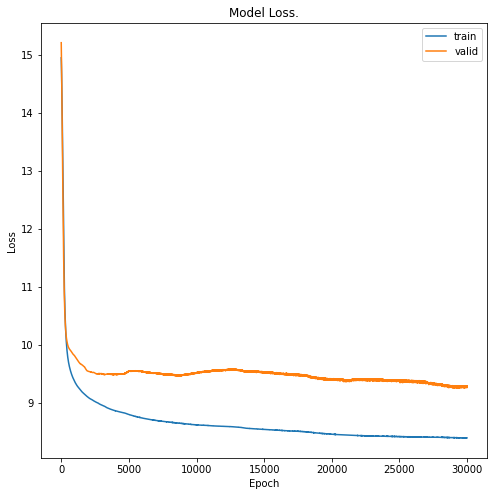

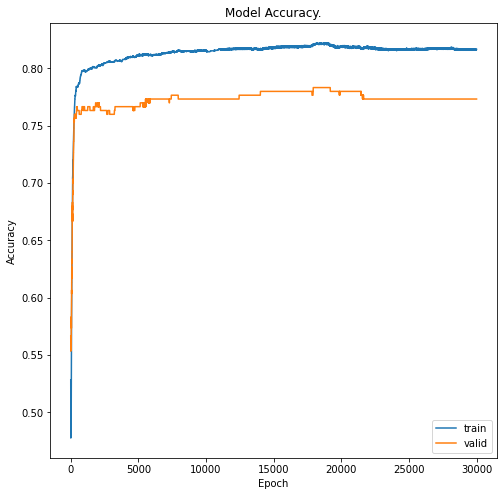



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 3103 based on val_loss
INFO:util.loop:Train loss: 0.005185980815440416
INFO:util.loop:Validation loss: 0.00840306282043457
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 6542 based on val_loss
INFO:util.loop:Train loss: 0.0005988319171592593
INFO:util.loop:Validation loss: 0.0024067966733127832
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 17384 based on val_loss
INFO:util.loop:Train loss: 8.335291568073444e-07
INFO:util.loop:Validation loss: 4.172319023609816e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 29746 based on val_loss
INFO:util.loop:Train loss: 7.9112701416015625
INFO:util.loop:Validation loss: 8.419149398803711
INFO:util.loop:Train acc: 81.29167%
INFO:util.loop:Validation acc: 79.00000%


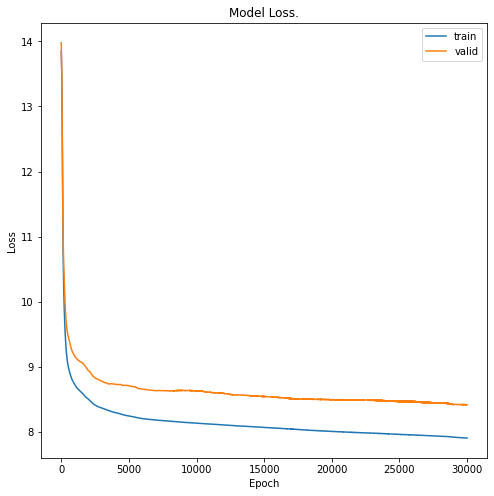

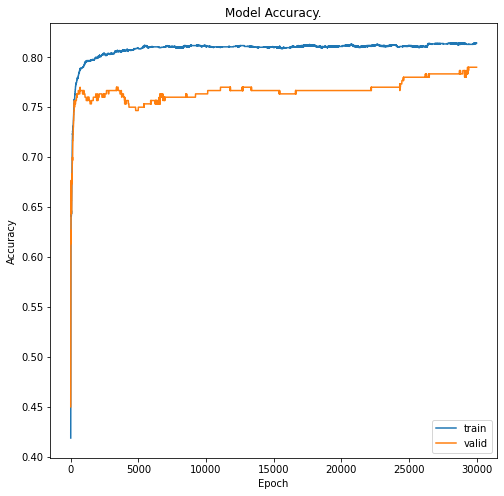



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 2932 based on val_loss
INFO:util.loop:Train loss: 0.006089650094509125
INFO:util.loop:Validation loss: 0.019291620701551437
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 19966 based on val_loss
INFO:util.loop:Train loss: 1.677851599879432e-07
INFO:util.loop:Validation loss: 2.741778075687762e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 14321 based on val_loss
INFO:util.loop:Train loss: 4.84237534692511e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Checkpoint Epoch 29341 based on val_loss
INFO:util.loop:Train loss: 8.831038475036621
INFO:util.loop:Validation loss: 9.208673477172852
INFO:util.loop:Train acc: 80.99999%
INFO:util.loop:Validation acc: 77.66666%


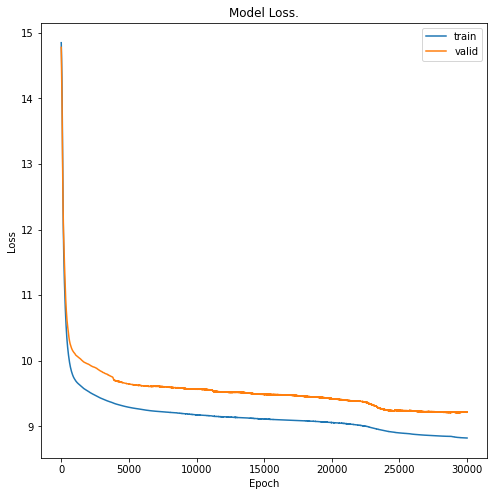

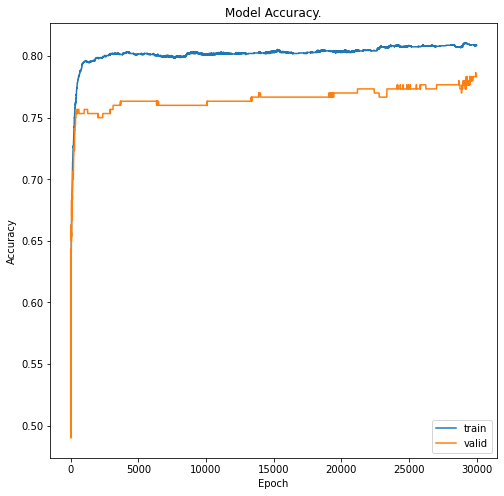



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 2287 based on val_loss
INFO:util.loop:Train loss: 0.008052372373640537
INFO:util.loop:Validation loss: 0.021643083542585373
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 11138 based on val_loss
INFO:util.loop:Train loss: 2.1469813873409294e-05
INFO:util.loop:Validation loss: 0.014204350300133228
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 18380 based on val_loss
INFO:util.loop:Train loss: 1.3485955605574418e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 24012 based on val_loss
INFO:util.loop:Train loss: 8.056867599487305
INFO:util.loop:Validation loss: 8.36988353729248
INFO:util.loop:Train acc: 81.12500%
INFO:util.loop:Validation acc: 77.66666%


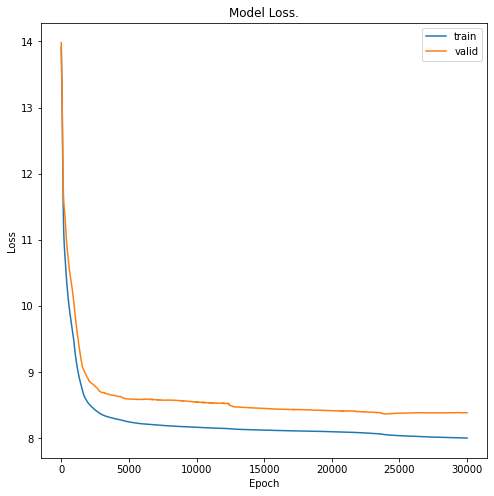

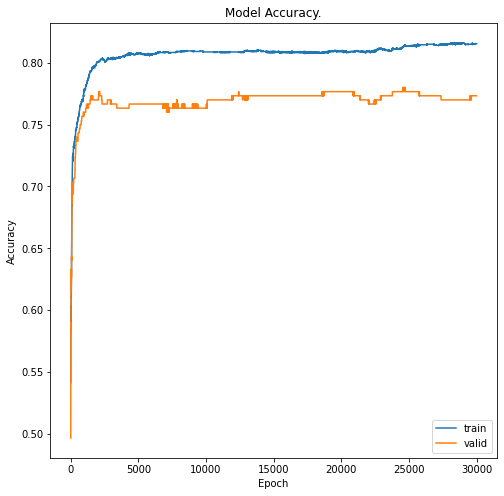

In [4]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, checkpoint_val_best="loss", 
                                         plot=False, logfile=f"data0.25_q31_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.3
    T = 9
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, checkpoint_val_best="loss", 
                                             plot=True, logfile=f"data0.25_q31_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 78.066664% +/- 0.007226487571170766


## Method 2: Annealing Knowledge Distillation

Annealing temperature value would allow the student to learn from flatter convex curvatures (non-convex here considered as a combination of convex landscapes), there by starting from a reduced differences in the multiple domain functions, i.e., adapting from the common feature learning.

The solution is adapted from the following reference. Instead of training with annealing T=1 steps and then fine-tuning with CE, alpha weighting is implemented to do it simultaneously.

_Ref: Jafari, A., Rezagholizadeh, M., Sharma, P. and Ghodsi, A., 2021, April. Annealing Knowledge Distillation. 
       In Proceedings of the 16th Conference of the European Chapter of the Association for Computational Linguistics: 
       Main Volume (pp. 2493-2504)._



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 13094 based on val_loss
INFO:util.loop:Train loss: 1.653385152167175e-05
INFO:util.loop:Validation loss: 8.034537017920229e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 20253 based on val_loss
INFO:util.loop:Train loss: 1.00730794372339e-07
INFO:util.loop:Validation loss: 0.019461367279291153
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 14320 based on val_loss
INFO:util.loop:Train loss: 4.400189482112182e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Checkpoint Epoch 30000 based on val_loss
INFO:util.loop:Train loss: 27878.978515625
INFO:util.loop:Validation loss: 40371.31640625
INFO:util.loop:Train acc: 68.08333%
INFO:util.loop:Validation acc: 69.66667%


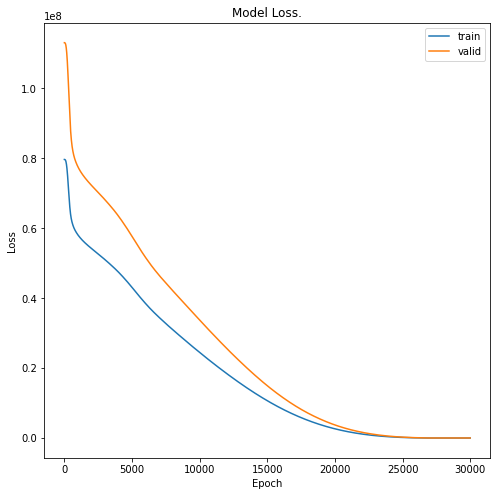

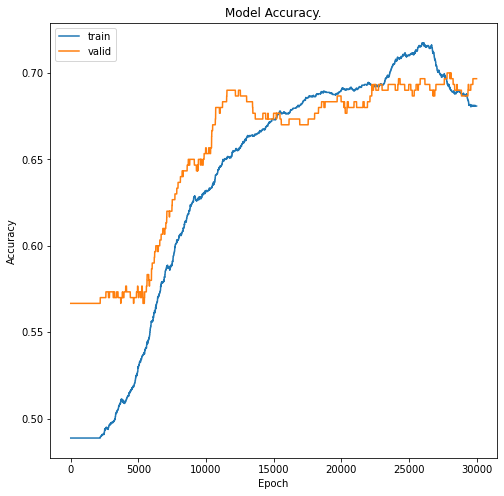



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 21910 based on val_loss
INFO:util.loop:Train loss: 1.8265681092088926e-06
INFO:util.loop:Validation loss: 1.3455706721288152e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 29917 based on val_loss
INFO:util.loop:Train loss: 7.450579597723106e-10
INFO:util.loop:Validation loss: 4.529942287945232e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 28464 based on val_loss
INFO:util.loop:Train loss: 2.384185515680315e-09
INFO:util.loop:Validation loss: 1.1920927578401574e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Checkpoint Epoch 30000 based on val_loss
INFO:util.loop:Train loss: 40434.76953125
INFO:util.loop:Validation loss: 47548.25
INFO:util.loop:Train acc: 61.70833%
INFO:util.loop:Validation acc: 62.66666%


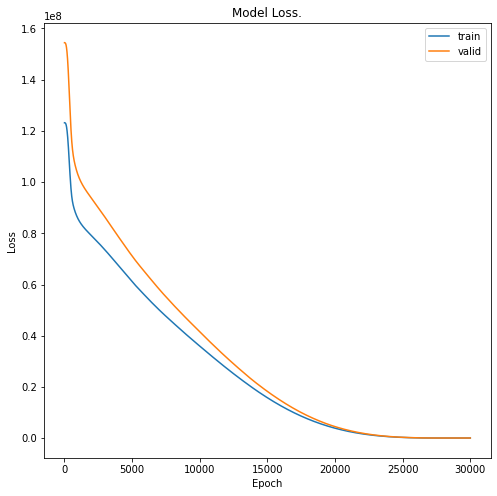

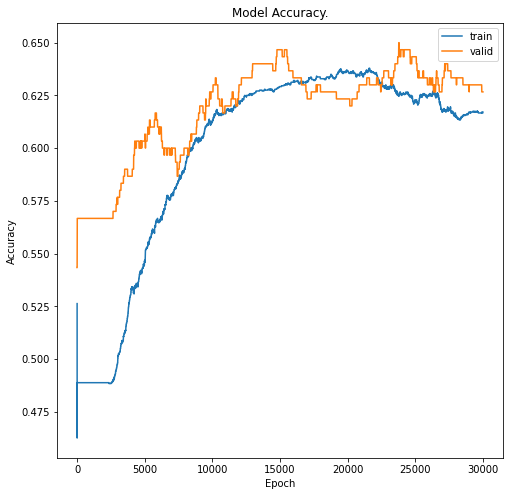



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 3103 based on val_loss
INFO:util.loop:Train loss: 0.005185980815440416
INFO:util.loop:Validation loss: 0.00840306282043457
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 6542 based on val_loss
INFO:util.loop:Train loss: 0.0005988319171592593
INFO:util.loop:Validation loss: 0.0024067966733127832
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 17384 based on val_loss
INFO:util.loop:Train loss: 8.335291568073444e-07
INFO:util.loop:Validation loss: 4.172319023609816e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 29994 based on val_loss
INFO:util.loop:Train loss: 9245.333984375
INFO:util.loop:Validation loss: 14904.10546875
INFO:util.loop:Train acc: 60.25000%
INFO:util.loop:Validation acc: 65.33333%


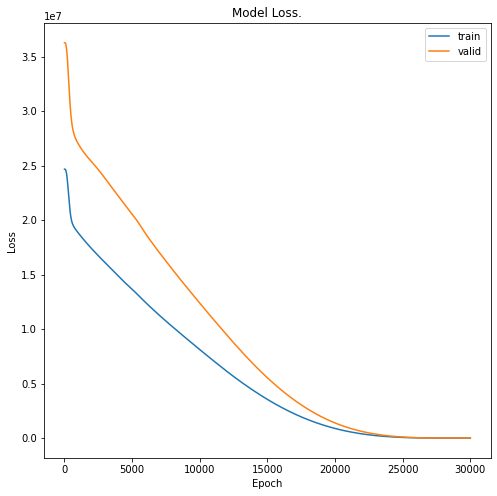

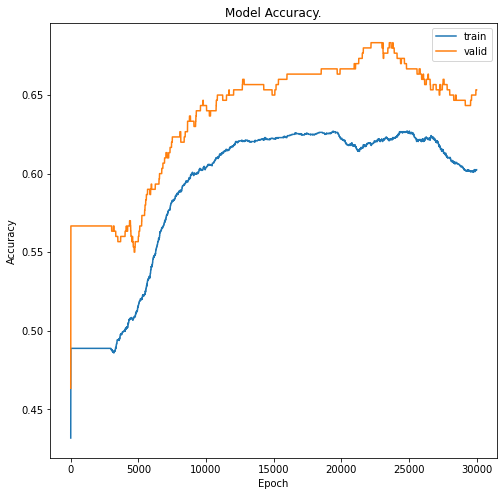



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 2932 based on val_loss
INFO:util.loop:Train loss: 0.006089650094509125
INFO:util.loop:Validation loss: 0.019291620701551437
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 19966 based on val_loss
INFO:util.loop:Train loss: 1.677851599879432e-07
INFO:util.loop:Validation loss: 2.741778075687762e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 14321 based on val_loss
INFO:util.loop:Train loss: 4.84237534692511e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Checkpoint Epoch 29993 based on val_loss
INFO:util.loop:Train loss: 15253.9677734375
INFO:util.loop:Validation loss: 25364.732421875
INFO:util.loop:Train acc: 70.62500%
INFO:util.loop:Validation acc: 70.33333%


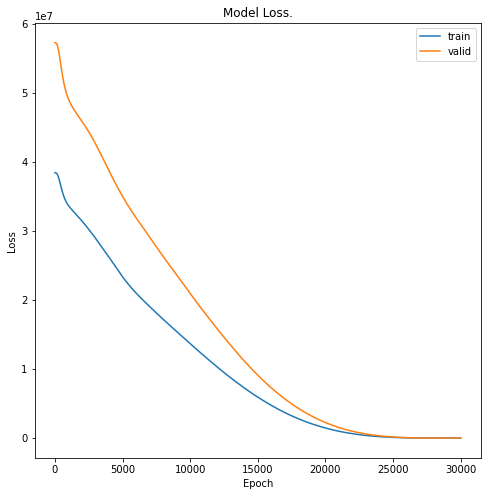

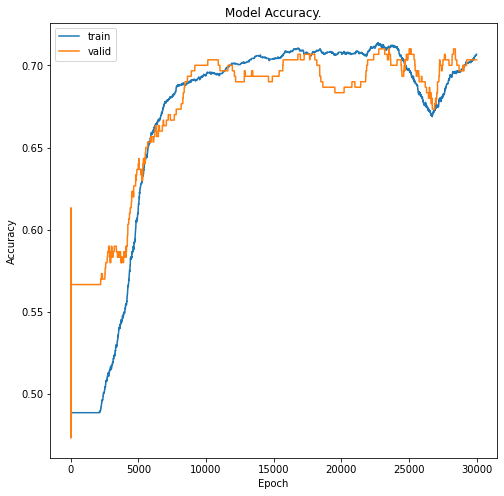



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 2287 based on val_loss
INFO:util.loop:Train loss: 0.008052372373640537
INFO:util.loop:Validation loss: 0.021643083542585373
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 11138 based on val_loss
INFO:util.loop:Train loss: 2.1469813873409294e-05
INFO:util.loop:Validation loss: 0.014204350300133228
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 18380 based on val_loss
INFO:util.loop:Train loss: 1.3485955605574418e-06
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 30000 based on val_loss
INFO:util.loop:Train loss: 19294.880859375
INFO:util.loop:Validation loss: 31103.912109375
INFO:util.loop:Train acc: 66.62500%
INFO:util.loop:Validation acc: 69.00000%


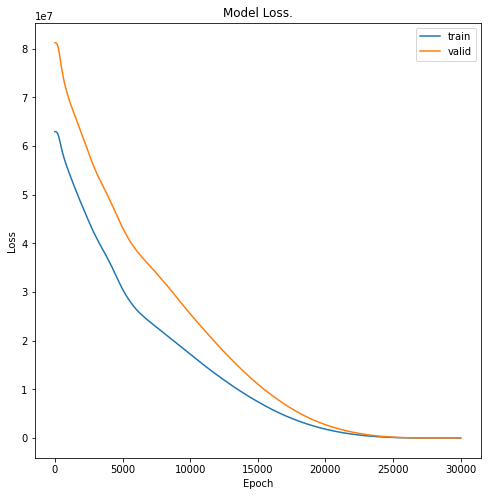

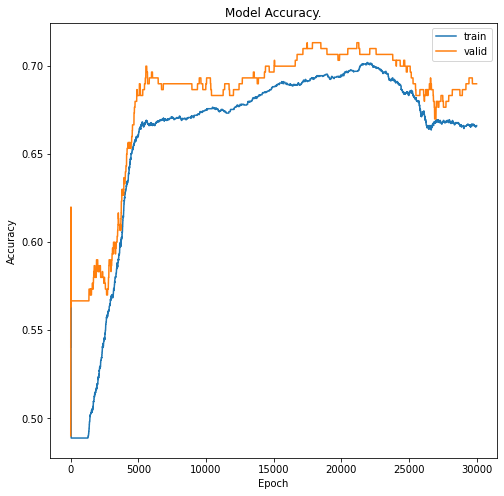

In [4]:
import torch
from util.model import FFNN
from util.loop import train, student_train_KD_annealing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, checkpoint_val_best="loss", 
                                         plot=False, logfile=f"data0.25_q32_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Annealing Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.72
    T_max = 33
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train_KD_annealing(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T_max, checkpoint_val_best="loss", 
                                                          plot=True, logfile=f"data0.25_q32_student_random_state_{random_state}_{T_max}")

    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 67.399998% +/- 0.032778740553993616
